# Apartat (C): Analitzant Dades


In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns;
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('data/OnionPrices.csv')
# Eliminem la columna commodity perque es irrelevant
del dataset["commodity"]

dataset.drop(dataset.loc[dataset['max_price'] == 0].index, inplace=True)
dataset.drop(dataset.loc[dataset['min_price'] == 0].index, inplace=True)

#Guardem les noves dades en un csv i les carguem un altre cop
dataset.to_csv("data/OnionPrices_2.csv")
dataset = load_dataset('data/OnionPrices_2.csv')
del dataset["Unnamed: 0"]

data = dataset.values
x = data[:, :]
y_modal_price = data[:, -1]


In [2]:
# Visualitzar les dades
dataset.head() 

,state,district,market,variety,arrival_date,min_price,max_price,modal_price
0,Andhra Pradesh,Kurnool,Kurnool,Local,03/01/2020,1350,4390,3100.000
1,Andhra Pradesh,Kurnool,Kurnool,Local,04/01/2020,1390,4400,3200.000
2,Andhra Pradesh,Kurnool,Kurnool,Local,06/01/2020,1460,5150,4310.000
3,Andhra Pradesh,Kurnool,Kurnool,Local,07/01/2020,2010,5200,4200.000
4,Andhra Pradesh,Kurnool,Kurnool,Local,10/01/2020,1320,4050,3300.000


In [3]:
# Comprova quants valors de cada atribut son únics
print("Numero de mercados:", len(dataset['market'].unique()))
print("Numero de distritos:", len(dataset['district'].unique()))
print("Numero de estados:", len(dataset['state'].unique()))
print("Numero de variedad:", len(dataset['variety'].unique()))

Numero de mercados: 905
Numero de distritos: 315
Numero de estados: 22
Numero de variedad: 21


In [5]:
#Mostrem de cada atribut categoritzable els seus valors únics.
print("Estados:", dataset['state'].unique())
print("=================================")
print("Variedad:", dataset['variety'].unique())
print("=================================")
print("Market:", dataset['market'].unique())
print("=================================")
print("District:", dataset['district'].unique())

Estados: ['Andhra Pradesh' 'Chattisgarh' 'Goa' 'Gujarat' 'Haryana'
 'Himachal Pradesh' 'Jammu and Kashmir' 'Jharkhand' 'Karnataka' 'Kerala'
 'Madhya Pradesh' 'Maharashtra' 'Nagaland' 'NCT of Delhi' 'Odisha'
 'Punjab' 'Rajasthan' 'Telangana' 'Tripura' 'Uttar Pradesh' 'Uttrakhand'
 'West Bengal']
Variedad: ['Local' 'Other' 'Onion' 'Nasik' 'Red' 'White' 'Beelary-Red' '1st Sort'
 'Bangalore-Samall' 'Puna' 'Pusa-Red' 'Bombay (U.P.)' 'Telagi' 'Hybrid'
 'Big' 'Small' '2nd Sort' 'Pole' 'Dry F.A.Q.' 'Medium' 'Bellary']
Market: ['Kurnool' 'Pattikonda' 'Tiphra' 'Durg' 'Raigarh' 'Rajnandgaon' 'Mapusa'
 'Ahmedabad(Chimanbhai Patal Market Vasana)' 'Dhari'
 'Anand(Veg,Yard,Anand)' 'Khambhat(Veg Yard Khambhat)'
 'Petlad(Veg Yard, Petlad)' 'Deesa(Deesa Veg Yard)' 'Bharuch' 'Bhavnagar'
 'Mahuva(Station Road)' 'Dahod(Veg. Market)' 'Jamnagar' 'Visavadar'
 'Kapadvanj' 'Nadiyad(Piplag)' 'Mehsana(Mehsana Veg)' 'Bilimora' 'Godhra'
 'Porbandar' 'Gondal' 'Jetpur(Dist.Rajkot)' 'Morbi' 'Rajkot(Ghee Peeth)'
 'Song

In [6]:
#Estadistiques sobre la nostre col·lecció de dades
print(dataset.describe())

       min_price  max_price  modal_price
count 107105.000 107105.000   107105.000
mean    1896.110   2293.933     2109.441
std     1459.381   1564.327     1493.184
min       20.000     54.000       20.000
25%     1000.000   1225.000     1150.000
50%     1400.000   1800.000     1600.000
75%     2400.000   2800.000     2550.000
max    18000.000  25000.000    22000.000


In [7]:
# Desglosem el atribut arrival date, per mes i dia
dataset['arrival_date'] = pd.to_datetime(dataset['arrival_date'])
dataset['month'] = pd.DatetimeIndex(dataset['arrival_date']).month
dataset['day'] = pd.DatetimeIndex(dataset['arrival_date']).day

dataset

/tmp/ipykernel_18189/1990634617.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dataset['arrival_date'] = pd.to_datetime(dataset['arrival_date'])


,state,district,market,variety,arrival_date,min_price,max_price,modal_price,month,day
0,Andhra Pradesh,Kurnool,Kurnool,Local,2020-03-01,1350,4390,3100.000,3,1
1,Andhra Pradesh,Kurnool,Kurnool,Local,2020-04-01,1390,4400,3200.000,4,1
2,Andhra Pradesh,Kurnool,Kurnool,Local,2020-06-01,1460,5150,4310.000,6,1
3,Andhra Pradesh,Kurnool,Kurnool,Local,2020-07-01,2010,5200,4200.000,7,1
4,Andhra Pradesh,Kurnool,Kurnool,Local,2020-10-01,1320,4050,3300.000,10,1
...,...,...,...,...,...,...,...,...,...,...
107100,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-03-09,2200,2300,2250.000,3,9
107101,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-04-09,2050,2600,2200.000,4,9
107102,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-08-09,2700,2875,2800.000,8,9
107103,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-09-09,2625,2875,2800.000,9,9


In [8]:
# Es transforme l'atribut arrival_time que es un objecte al tipus data
print(dataset.dtypes)

state                   object
district                object
market                  object
variety                 object
arrival_date    datetime64[ns]
min_price                int64
max_price                int64
modal_price            float64
month                    int64
day                      int64
dtype: object


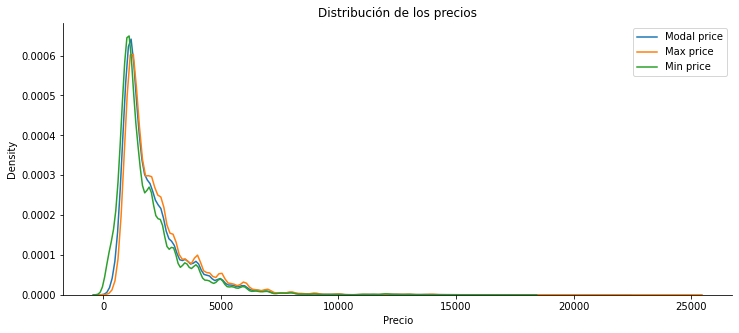

In [313]:
#Gráfic sobre la densitat dels preus, comprovem quina distribució tenim.
plt.figure(figsize=(12, 5))
sns.kdeplot(data=dataset['modal_price'], label='Modal price')
sns.kdeplot(data=dataset['max_price'], label='Max price')
sns.kdeplot(data=dataset['min_price'], label='Min price' )

plt.title('Distribución de los precios')
plt.xlabel('Precio')
plt.legend()
sns.despine()
plt.show()

També podem estudiar la correlació entre els diferents atributs per tal de saber si estan correlacionats entre ells.

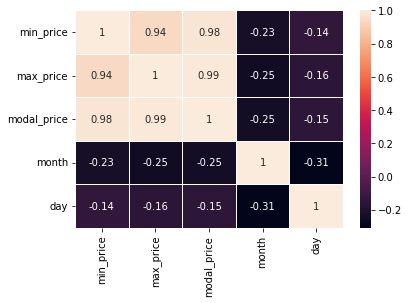

In [314]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

També podem utilitzar la funció pairplot per tal de veure els atributs que estan relacionats entre si.

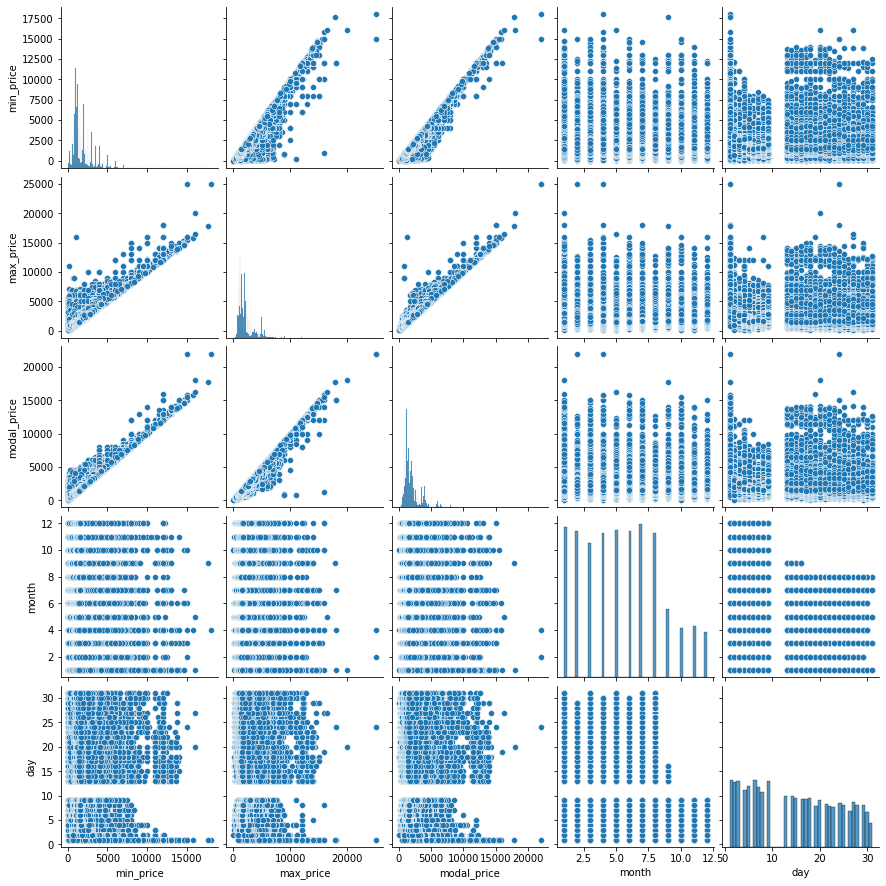

In [315]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset)

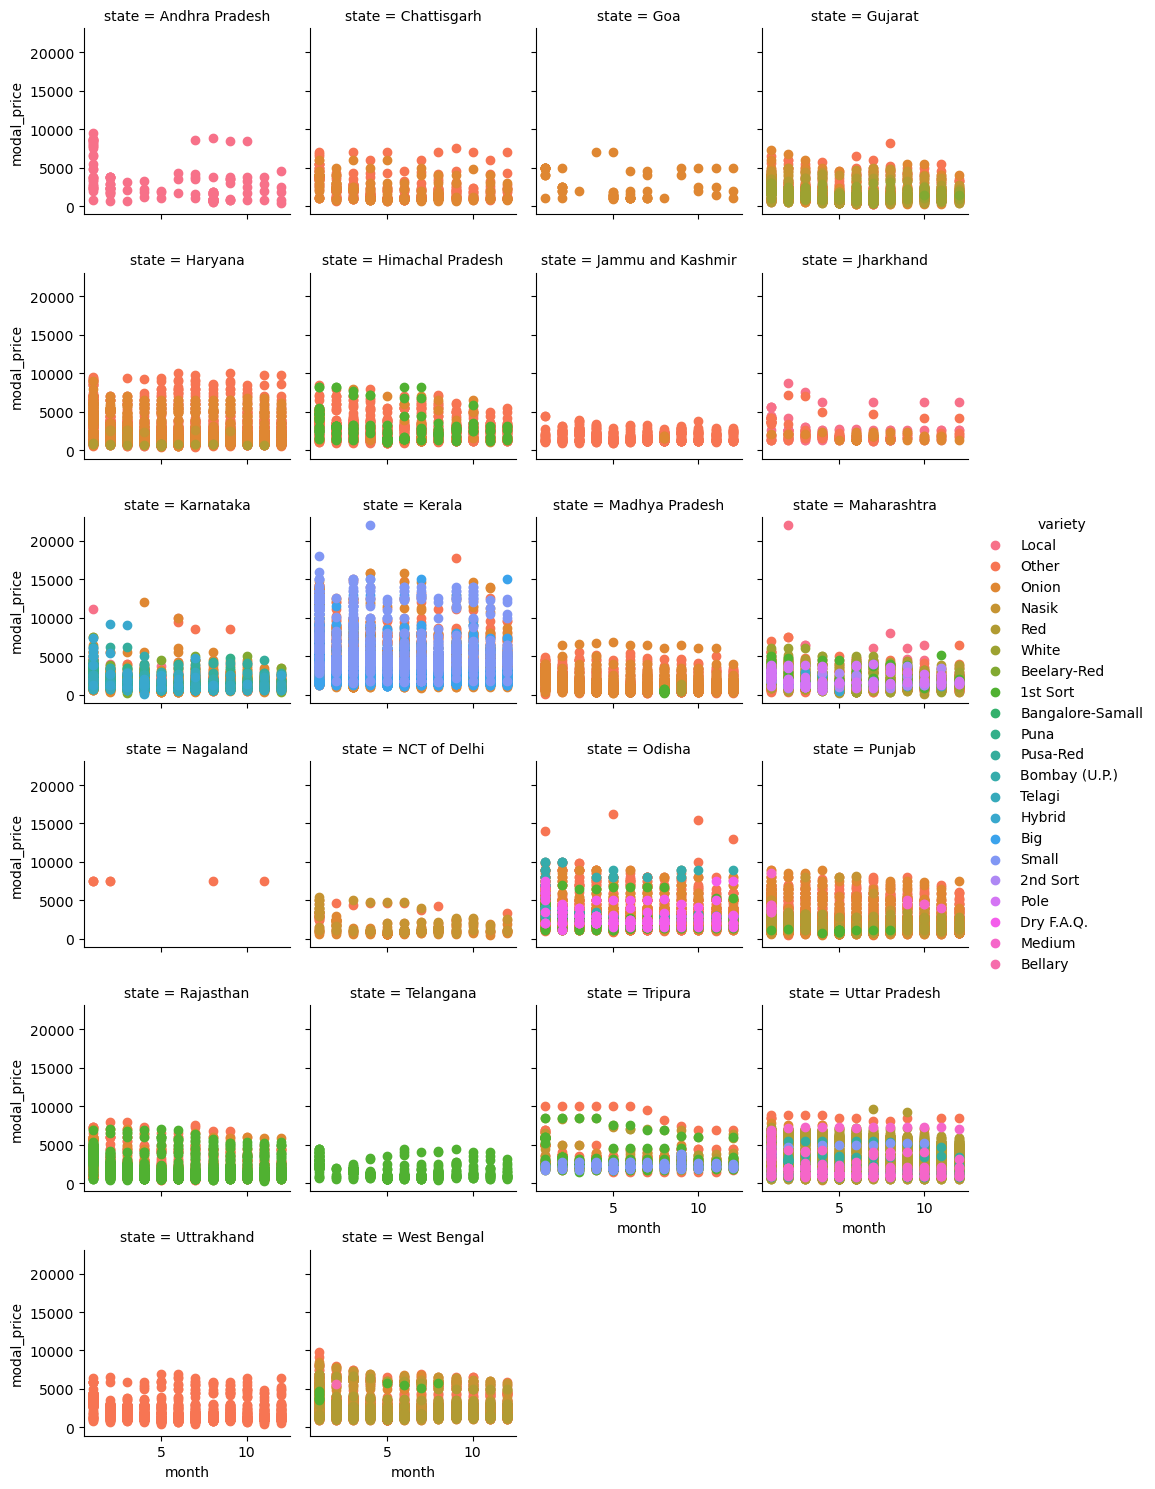

In [20]:
#Grafiques de cada estat sobre la varietat, on la x son els mesos, la y el preu model.
g = sns.FacetGrid(dataset,  col="state",hue="variety", col_wrap=4, height=2.5)
g.map(plt.scatter,"month","modal_price")
g.add_legend()


# Apartat (B): Primeres regressions


In [316]:
plt.figure(figsize=(30,10))
plt.title("Histograma de l'atribut 0")
plt.xlabel("Attribute Value")
plt.ylabel("Count")

hist = plt.hist(x[:,-1], bins=len( set(x[:,-1])), rwidth=0.2)
plt.gcf().autofmt_xdate()
plt.savefig("images/histModalPrice.png",dpi = 300, bbox_inches = 'tight')
plt.clf()

for i in range(7):
    plt.title("Histograma de l'atribut ")
    plt.xlabel(dataset.columns[i])
    plt.ylabel("Count")
    hist = plt.hist(x[:,i] , bins=len( set(x[:,i])),  rwidth=0.2)
    plt.gcf().autofmt_xdate()
    plt.savefig("images/histogramas/hist" + dataset.columns[i] + ".png", dpi = 300, bbox_inches = 'tight')
    plt.clf()

<Figure size 2160x720 with 0 Axes>

In [10]:

train_dataset = dataset
train_dataset.drop(['arrival_date'], axis=1, inplace=True)

train_dataset.head()

,state,district,market,variety,min_price,max_price,modal_price,month,day
0,Andhra Pradesh,Kurnool,Kurnool,Local,1350,4390,3100.000,3,1
1,Andhra Pradesh,Kurnool,Kurnool,Local,1390,4400,3200.000,4,1
2,Andhra Pradesh,Kurnool,Kurnool,Local,1460,5150,4310.000,6,1
3,Andhra Pradesh,Kurnool,Kurnool,Local,2010,5200,4200.000,7,1
4,Andhra Pradesh,Kurnool,Kurnool,Local,1320,4050,3300.000,10,1


In [11]:
# Categorització de la nostra col·lecció, farem una categorització de state i variety
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


train_dataset_state_variety = train_dataset[['state','variety', 'min_price', 'max_price', 'month', 'day']]
train_df_x_variety = train_dataset[['variety', 'min_price', 'max_price', 'month', 'day']]
train_df_x_state = train_dataset[['state', 'min_price', 'max_price', 'month', 'day']]
train_df_y = train_dataset['modal_price']

df_x_prices = train_dataset[['min_price', 'max_price']]
df_x_max_price = train_dataset[ 'max_price']


def replace_categorical(df):  
    columns = df.columns
    for col in columns:
        if df[col].dtype == 'object':
            df = pd.concat([df, pd.get_dummies(df[col],prefix=col)], axis=1)
            df = df.drop(columns=col)
    
    return df


train_dataset_state_variety = replace_categorical(train_dataset_state_variety)
train_df_x_variety = replace_categorical(train_df_x_variety)
train_df_x_state = replace_categorical(train_df_x_state)
train_dataset_state_variety

,min_price,max_price,month,day,state_Andhra Pradesh,state_Chattisgarh,state_Goa,state_Gujarat,state_Haryana,state_Himachal Pradesh,...,variety_Nasik,variety_Onion,variety_Other,variety_Pole,variety_Puna,variety_Pusa-Red,variety_Red,variety_Small,variety_Telagi,variety_White
0,1350,4390,3,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1390,4400,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1460,5150,6,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010,5200,7,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1320,4050,10,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107100,2200,2300,3,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
107101,2050,2600,4,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
107102,2700,2875,8,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
107103,2625,2875,9,9,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

In [13]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

def mse(v1, v2):
    return ((v1 - v2)**2).mean()


In [14]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

In [15]:
def standarize(x, mean=None, std=None):
    if mean is None:
        mean = x.mean(0)
    if std is None:
        std = x.std(0)
    
    return (x - mean[None, :]) / std[None, :], mean, std

train_df_x_norm, mean, std = standarize(train_dataset_state_variety.values)
train_df_x_norm_variety, mean, std = standarize(train_df_x_variety.values)
train_df_x_norm_state, mean, std = standarize(train_df_x_state.values)

train_df_y_norm, mean, std = standarize(train_df_y.values[:, None])
df_x_prices_norm, mean, std = standarize(df_x_prices.values)

#Normalització dels valors
train_df_x_norm


array([[-0.37420816,  1.33992296, -0.79899862, ..., -0.12535512,
        -0.03278516, -0.06779363],
       [-0.34679915,  1.34631552, -0.46805108, ..., -0.12535512,
        -0.03278516, -0.06779363],
       [-0.2988334 ,  1.82575731,  0.19384402, ..., -0.12535512,
        -0.03278516, -0.06779363],
       ...,
       [ 0.55084567,  0.37145054,  0.85573911, ..., -0.12535512,
        -0.03278516, -0.06779363],
       [ 0.49945379,  0.37145054,  1.18668666, ..., -0.12535512,
        -0.03278516, -0.06779363],
       [ 0.61936818,  0.38103938,  1.5176342 , ..., -0.12535512,
        -0.03278516, -0.06779363]])

<AxesSubplot: >

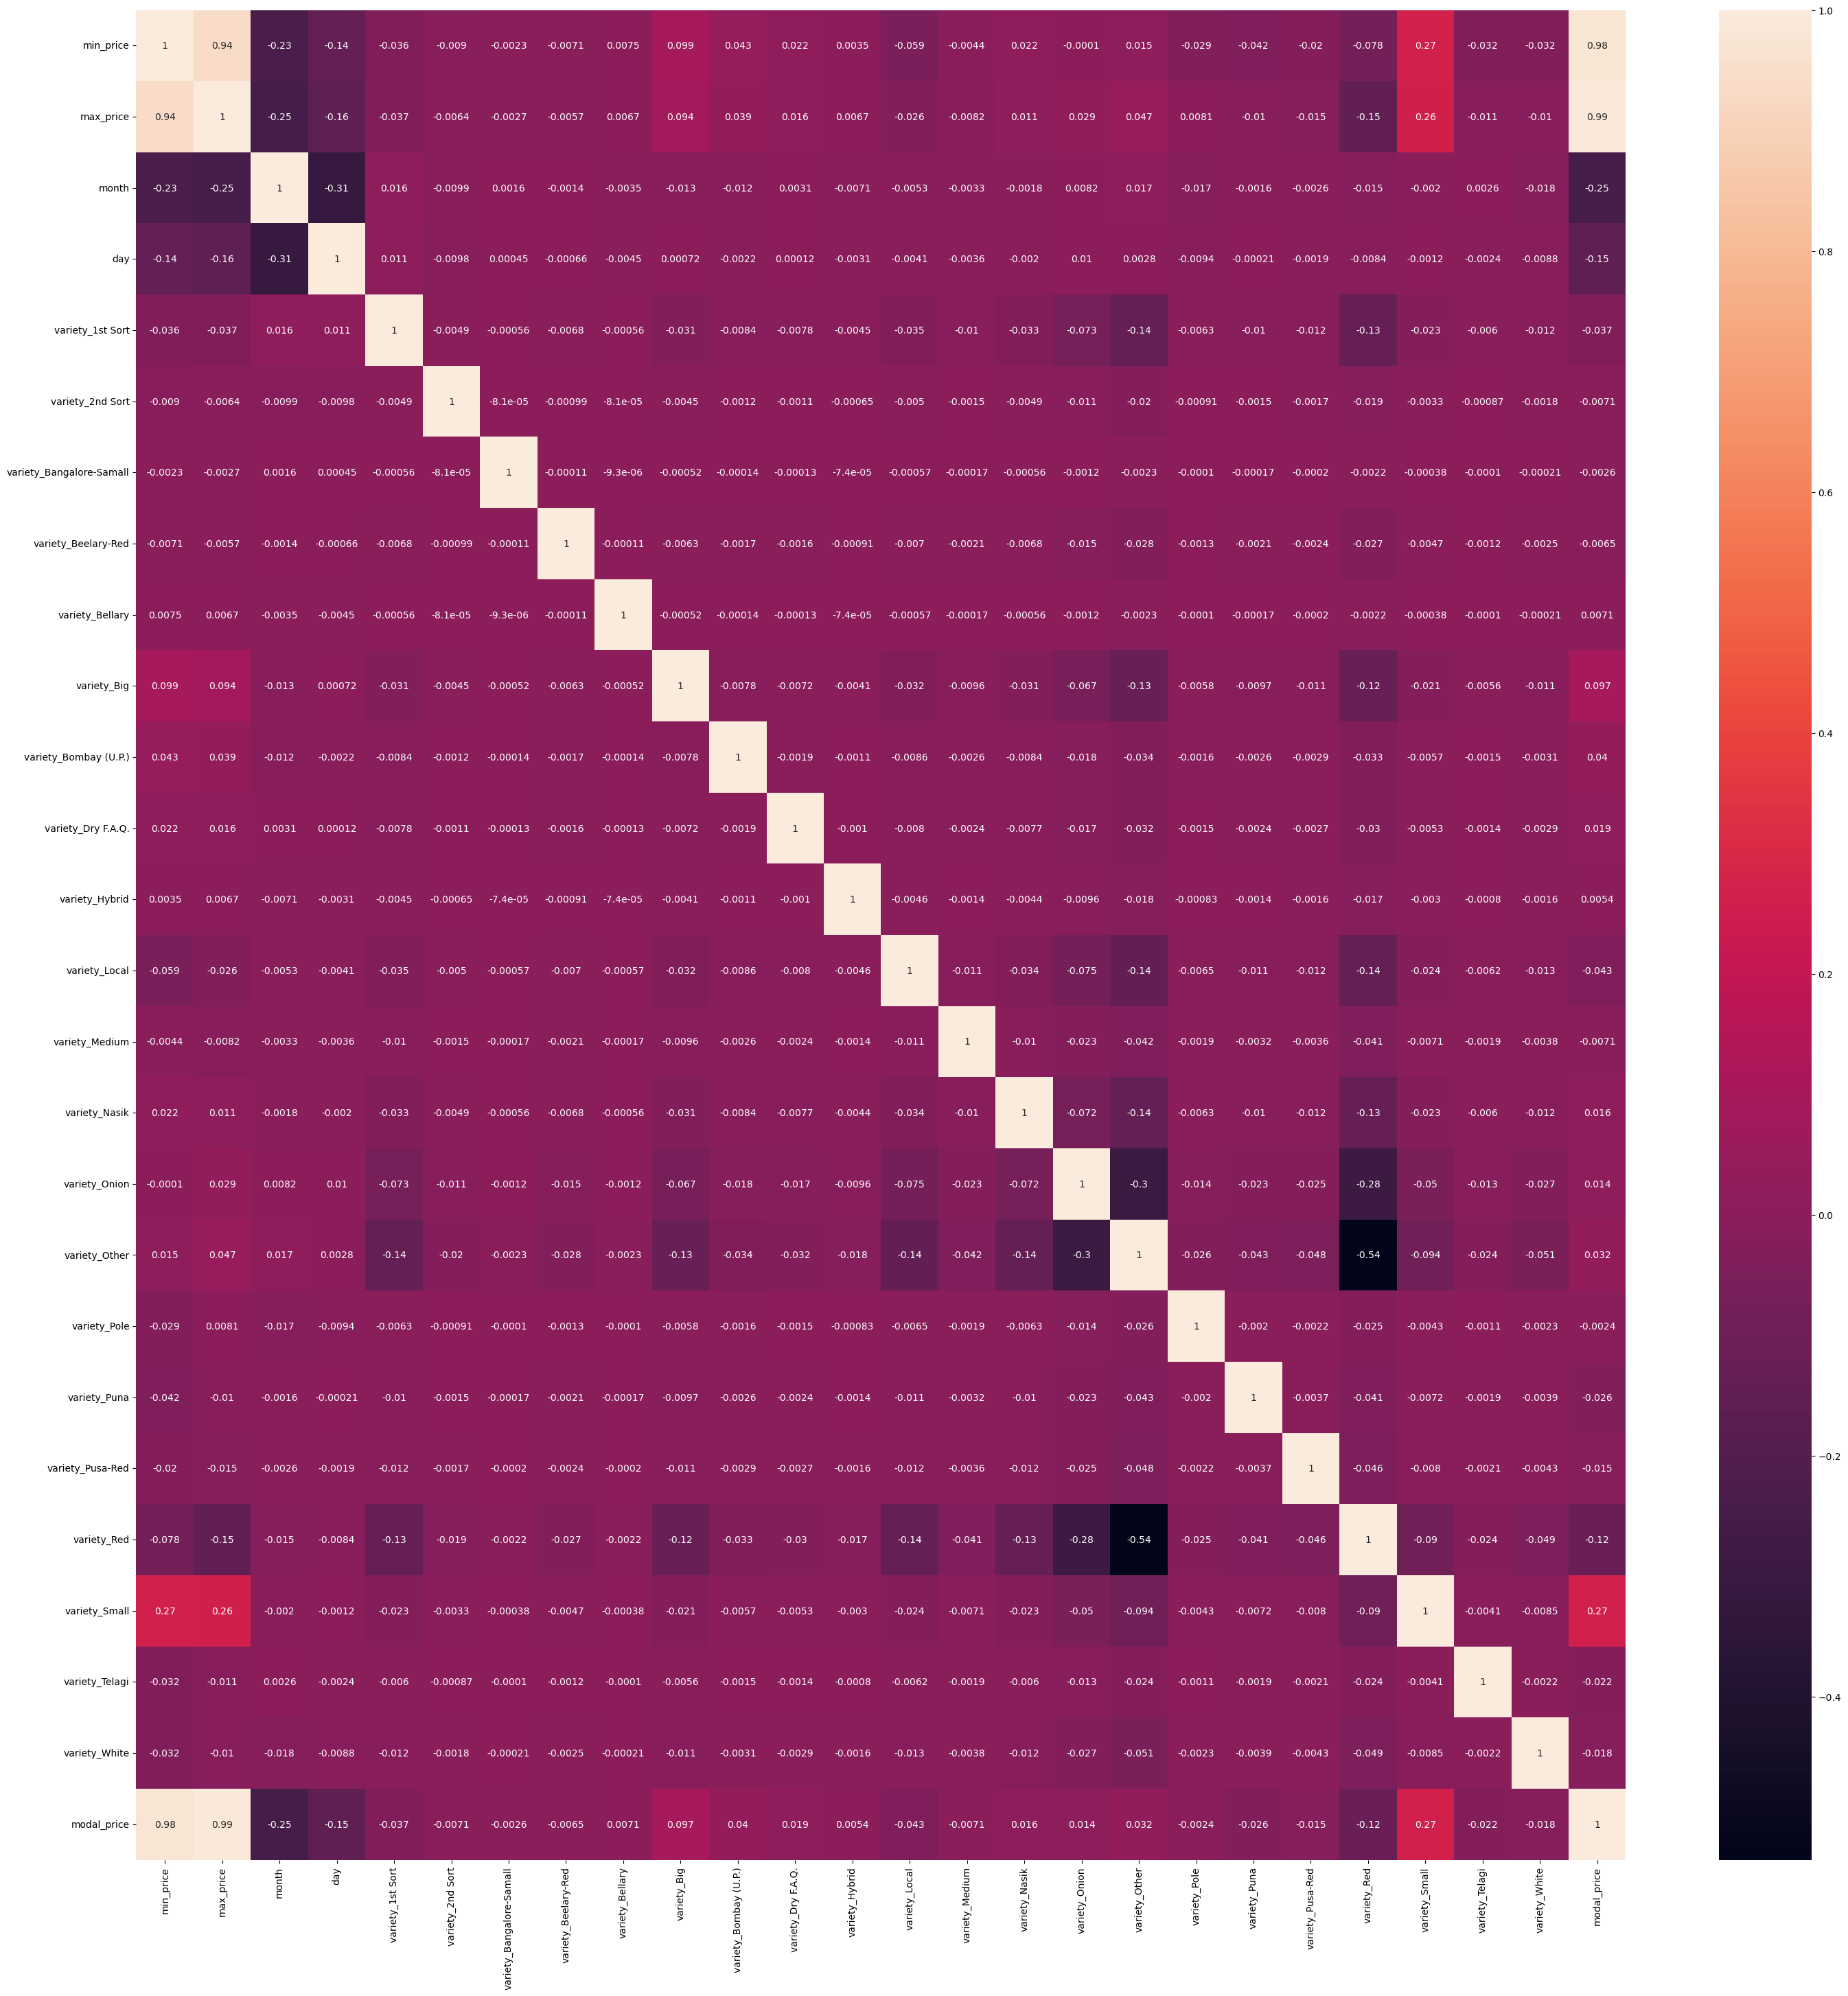

In [16]:
correlation_df_variety_price = pd.concat([train_df_x_variety, train_df_y], axis=1)
f, ax = plt.subplots(figsize=(35,35))
sns.heatmap(correlation_df_variety_price.corr(), annot=True)

<AxesSubplot: >

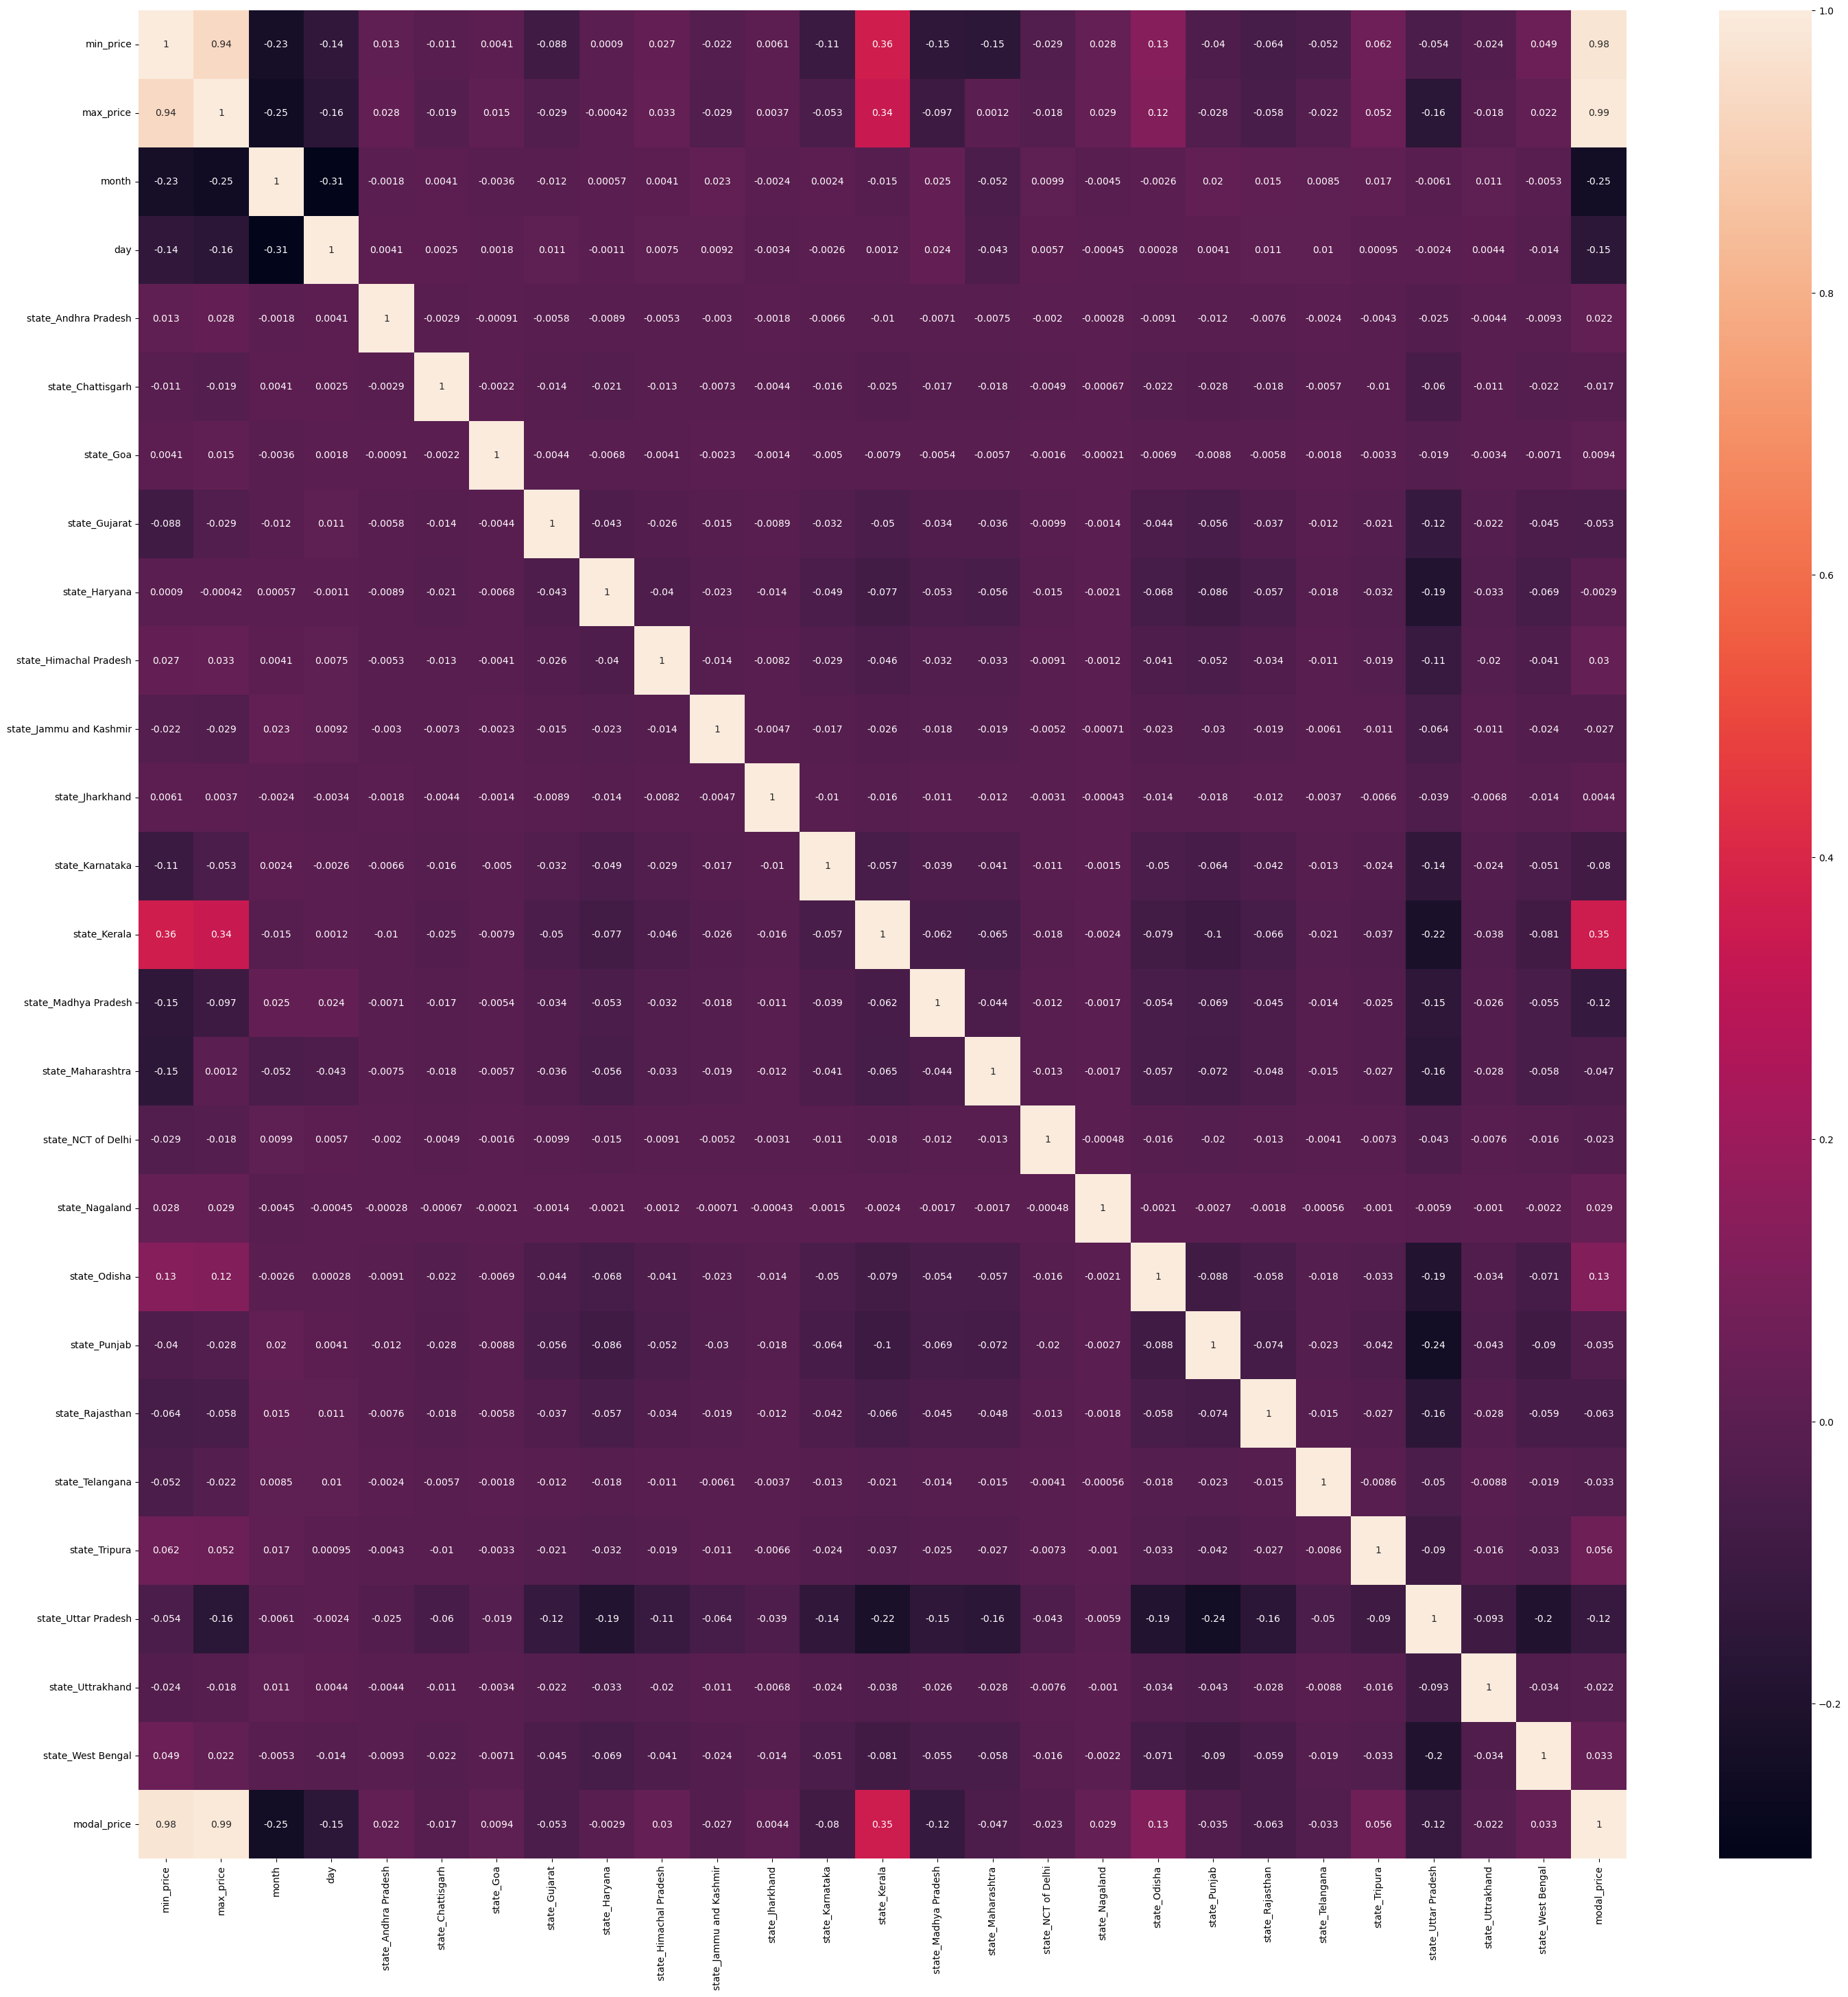

In [17]:
correlation_df_state_price = pd.concat([train_df_x_state, train_df_y], axis=1)
f, ax = plt.subplots(figsize=(35,35))
sns.heatmap(correlation_df_state_price.corr(), annot=True)

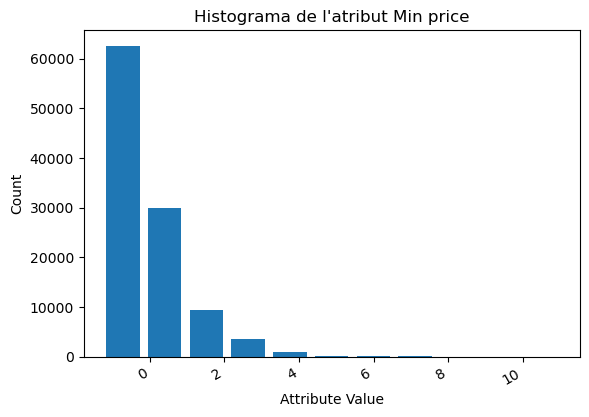

In [18]:
plt.figure()
plt.title("Histograma de l'atribut Min price")
plt.xlabel("Attribute Value")
plt.ylabel("Count")

plt.hist(train_df_x_norm[:,0], bins=11, range=[np.min(train_df_x_norm[:,0]), np.max(train_df_x_norm[:,0])], histtype="bar", rwidth=0.8)
plt.gcf().autofmt_xdate()
plt.show()

In [327]:
train_df_y_norm

array([[0.66338973],
       [0.73036101],
       [1.47374221],
       ...,
       [0.46247589],
       [0.46247589],
       [0.50935578]])

In [25]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
mse_array = {}
r2_array = {}
for k in range(47):
    atribut1 = train_df_x_norm[:,k].reshape(train_df_x_norm.shape[0], 1) 
    regr = regression(atribut1, train_df_y_norm) 
    predicted = regr.predict(atribut1)

    # Mostrem l'error (MSE i R2)
    MSE = mse(train_df_y_norm, predicted)
    mse_array[train_dataset_state_variety.columns[k]] = MSE
    r2 = r2_score(train_df_y_norm, predicted)
    r2_array[train_dataset_state_variety.columns[k]] = r2


In [37]:
#R2 de cada atribut
{j: l for j, l in sorted(r2_array.items(), key=lambda item: item[1])}

{'variety_Pole': 5.545431993714267e-06,
 'variety_Bangalore-Samall': 6.642437629045261e-06,
 'state_Haryana': 8.351419659824444e-06,
 'state_Jharkhand': 1.964720896618921e-05,
 'variety_Hybrid': 2.8982990835868527e-05,
 'variety_Beelary-Red': 4.223113829515679e-05,
 'variety_2nd Sort': 5.0015137394665565e-05,
 'variety_Medium': 5.0306668927468934e-05,
 'variety_Bellary': 5.1022455580529424e-05,
 'state_Goa': 8.880869036964611e-05,
 'variety_Onion': 0.00020322265233696513,
 'variety_Pusa-Red': 0.00022218701167164845,
 'variety_Nasik': 0.00026523454164883997,
 'state_Chattisgarh': 0.0002962059196721656,
 'variety_White': 0.00032334276501055914,
 'variety_Dry F.A.Q.': 0.0003711707712179546,
 'state_Andhra Pradesh': 0.000463421240872286,
 'state_Uttrakhand': 0.0004769438858474029,
 'variety_Telagi': 0.0004872707182489444,
 'state_NCT of Delhi': 0.0005451567965288895,
 'variety_Puna': 0.000691162845167681,
 'state_Jammu and Kashmir': 0.0007119002360186366,
 'state_Nagaland': 0.0008518466281

In [38]:
#MSE de cada atribut
{k: v for k, v in sorted(mse_array.items(), key=lambda item: item[1])}

{'max_price': 0.029336368281887938,
 'min_price': 0.049109596958403744,
 'state_Kerala': 0.8756996744565316,
 'variety_Small': 0.928526993317717,
 'month': 0.9384451948539462,
 'day': 0.9767166572473728,
 'state_Odisha': 0.9843498421705835,
 'state_Madhya Pradesh': 0.9845653858187791,
 'state_Uttar Pradesh': 0.9858562325085668,
 'variety_Red': 0.9863956527134728,
 'variety_Big': 0.9906624765014381,
 'state_Karnataka': 0.9935490987097628,
 'state_Rajasthan': 0.9960386422286412,
 'state_Tripura': 0.996864216868121,
 'state_Gujarat': 0.997150297578186,
 'state_Maharashtra': 0.9977963346131513,
 'variety_Local': 0.9981257402375677,
 'variety_Bombay (U.P.)': 0.9984061907337346,
 'variety_1st Sort': 0.998614675827218,
 'state_Punjab': 0.9987973336643474,
 'state_Telangana': 0.9989151169618434,
 'state_West Bengal': 0.9989235430796363,
 'variety_Other': 0.9989464567223513,
 'state_Himachal Pradesh': 0.9991056952969989,
 'state_Nagaland': 0.999148153371848,
 'state_Jammu and Kashmir': 0.999288

Text(0.5, 1.0, 'min_price')

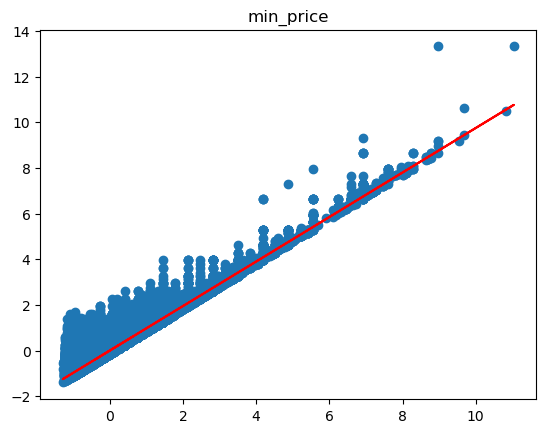

In [34]:
#Model per min price
atribut1 = train_df_x_norm[:,0].reshape(train_df_x_norm.shape[0], 1) 
regr = regression(atribut1, train_df_y_norm) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(train_df_x_norm[:,0], train_df_y_norm)
plt.plot(atribut1[:,0], predicted, 'r')
plt.title(train_dataset_state_variety.columns[0])




Text(0.5, 1.0, 'max_price')

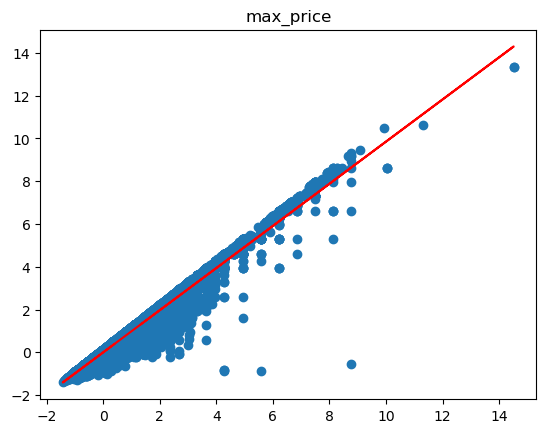

In [35]:
#Model per el max price
atribut1 = train_df_x_norm[:,1].reshape(train_df_x_norm.shape[0], 1) 
regr = regression(atribut1, train_df_y_norm) 
predicted = regr.predict(atribut1)

# Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
plt.figure()
ax = plt.scatter(train_df_x_norm[:,1], train_df_y_norm)
plt.plot(atribut1[:,0], predicted, 'r')
plt.title(train_dataset_state_variety.columns[1])


In [36]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(train_df_x_norm, train_df_y_norm)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))


Error en atribut 0: 0.046520
R2 score en atribut 0: 0.953231
Error en atribut 1: 0.027465
R2 score en atribut 1: 0.972389
Error en atribut 2: 0.932309
R2 score en atribut 2: 0.062711
Error en atribut 3: 0.968865
R2 score en atribut 3: 0.025960
Error en atribut 4: 0.994218
R2 score en atribut 4: 0.000472
Error en atribut 5: 0.994310
R2 score en atribut 5: 0.000379
Error en atribut 6: 0.994637
R2 score en atribut 6: 0.000050
Error en atribut 7: 0.991773
R2 score en atribut 7: 0.002929
Error en atribut 8: 0.994697
R2 score en atribut 8: -0.000010
Error en atribut 9: 0.993735
R2 score en atribut 9: 0.000958
Error en atribut 10: 0.993893
R2 score en atribut 10: 0.000798
Error en atribut 11: 0.994671
R2 score en atribut 11: 0.000016
Error en atribut 12: 0.988260
R2 score en atribut 12: 0.006461
Error en atribut 13: 0.875188
R2 score en atribut 13: 0.120137
Error en atribut 14: 0.978024
R2 score en atribut 14: 0.016752
Error en atribut 15: 0.992825
R2 score en atribut 15: 0.001872
Error en at

# Apartat (A): El descens del gradient  

In [43]:
# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

In [44]:
import time
from sklearn import linear_model
x_train, y_train, x_val, y_val = split_data(train_df_x_norm, train_df_y_norm)
#x_train, y_train, x_val, y_val = split_data(train_df_x_norm_variety, train_df_y_norm)
#x_train, y_train, x_val, y_val = split_data(train_df_x_norm_state, train_df_y_norm)
t1=time.time()
lm = LinearRegression() 
lm.fit(x_train,y_train)
print("The intercept term of the linear model:", lm.intercept_)
print("The coefficients of the linear model:", lm.coef_)
t2=time.time()
t_sklearn_linear = float(t2-t1)
print("Time taken: {} seconds".format(t_sklearn_linear)) 

The intercept term of the linear model: [-0.00039622]
The coefficients of the linear model: [[ 4.51619911e-01  5.60791899e-01 -1.16353985e-03 -4.73644894e-04
  -1.78585613e+10 -4.27821908e+10 -1.36354044e+10 -8.47735084e+10
  -1.25085067e+11 -7.81363670e+10 -4.54770448e+10 -2.75164604e+10
  -9.56905527e+10 -1.42732091e+11 -1.02219345e+11 -1.07237910e+11
  -3.04884761e+10 -4.19504932e+09 -1.27725277e+11 -1.56119938e+11
  -1.09191170e+11 -3.56185207e+10 -6.34321035e+10 -2.46900139e+11
  -6.54353813e+10 -1.30236934e+11  2.30593010e+11  3.45891406e+10
   3.96903645e+09  4.84147789e+10  3.96903645e+09  2.13945885e+11
   5.93412247e+10  5.48044993e+10  3.14941306e+10  2.36074542e+11
   7.33901292e+10  2.29311620e+11  4.45647180e+11  6.22582136e+11
   4.45263178e+10  7.39213764e+10  8.27074438e+10  6.15246728e+11
   1.60310759e+11  4.25405162e+10  8.76575721e+10]]
Time taken: 0.14576458930969238 seconds


In [45]:
import time
# Regressio lineal per min_price i max_price

x_train, y_train, x_val, y_val = split_data(df_x_prices_norm, train_df_y_norm)
t1=time.time()
lm = LinearRegression() 
lm.fit(x_train,y_train)
print("The intercept term of the linear model:", lm.intercept_)
print("The coefficients of the linear model:", lm.coef_)
t2=time.time()
t_sklearn_linear = float(t2-t1)
print("Time taken: {} seconds".format(t_sklearn_linear)) 

The intercept term of the linear model: [-0.00016776]
The coefficients of the linear model: [[0.42779028 0.58398615]]
Time taken: 0.008571624755859375 seconds


In [46]:
from sklearn.metrics import mean_squared_error
y_pred = lm.predict(x_val) 


y_d = desnormalitzar(y_val, mean, std)
res = desnormalitzar(y_pred, mean, std)
print(mean_squared_error(y_d,res))

recta_x = np.arange(-1,10,0.2)
print(x_val[:,1].size)
print (y_val.size)
print(x_val[:,0].size)

vec = np.vectorize(np.float)

x = np.array([x_val[-1000:,0]])
y = np.array([y_val[-1000:,0]])
z = np.array([x_val[-1000:,1]])

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(x,y,z, c='g',marker='o',alpha=0.6)
y = np.array([y_pred[-1000:,0]])
ax1.scatter(x,y,z, c='b',marker="^",alpha=0.6)
plt.savefig("images/resultats", dpi = 300, bbox_inches = 'tight')
plt.show()
plt.clf()


16445.398709592817
21421
21421
21421


<IPython.core.display.Javascript object>